If you took some discrete math courses, you have probably seen this sum
$$
\newcommand{\Bold}[1]{\mathbf{#1}}{\sum_{i=1}^{m} \frac{1}{i}}
$$
Let's try to compute it with [`SymPy.jl`](https://github.com/JuliaPy/SymPy.jl).

In [1]:
using SymPy
@vars i m;
harmonic = summation(1/i, (i, 1, m))

harmonic(m)

This is just to say, the sum is called the $m$-th [harmonic number](https://en.wikipedia.org/wiki/Harmonic_number), often written as $H_m$

The first ten harmonic numbers are

In [2]:
transpose(map(harmonic, 1:10))

1×10 LinearAlgebra.Transpose{Sym,Array{Sym,1}}:
 1  3/2  11/6  25/12  137/60  49/20  363/140  761/280  7129/2520  7381/2520

You probably remmber that $H_m \sim \log m$. This is to say that when $m$ is really large, the two numbers are quite close. Let's draw a picture.

In [3]:
using Plots; gr();

We load `LatexString` so we can use LaTeX in the plots.

In [4]:
using LaTeXStrings

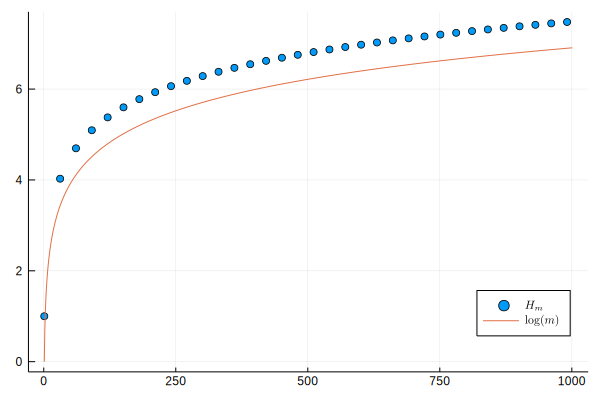

In [5]:
xpos = 1:30:1001;
harmonic_values = map(harmonic, xpos);
scatter(xpos, harmonic_values, label=L"H_m", legend=:bottomright)
plot!(log, 1:1001, label=L"\log(m)")

It looks like that $\log(m)$ is indeed close to $H_m$, but there seems to be a gap.

In fact, we can do much better. We know that
$$
H_m \sim \log m + \gamma + \frac{1}{2 m} - \sum_{k=1}^\infty \frac{B_{2 k}}{2 k m^{2 k}}
$$
where $\gamma$ is [Euler's constant](https://en.wikipedia.org/wiki/Euler%E2%80%93Mascheroni_constant) and $B_{k}$ are [Bernoulli numbers](https://en.wikipedia.org/wiki/Bernoulli_number). (One simple way to become immortal is to name a constant after yourself. 😅)

So if you want to be more precise, you just need to keep a few more terms in the above sum. Let's try this.

In [6]:
function harmonic_number_approx(m0, k0)
    return log(m0) + sympy.EulerGamma + 1/(2*m0) - sum([sympy.bernoulli(2*k)/(2*k*m^(2*k)) for k in  1:k0])
end

harmonic_number_approx (generic function with 1 method)

If we keep just one term, we get

In [7]:
h1 = harmonic_number_approx(m, 1)
h1

              1      1  
log(m) + γ + ─── - ─────
             2⋅m       2
                   12⋅m 

If we keep just two terms, we get

In [8]:
h2 = harmonic_number_approx(m, 2)
h2

              1      1       1   
log(m) + γ + ─── - ───── + ──────
             2⋅m       2        4
                   12⋅m    120⋅m 

Let's see how this works.

In [10]:
h1_values = map(h1, xpos);
h2_values = map(h2, xpos);

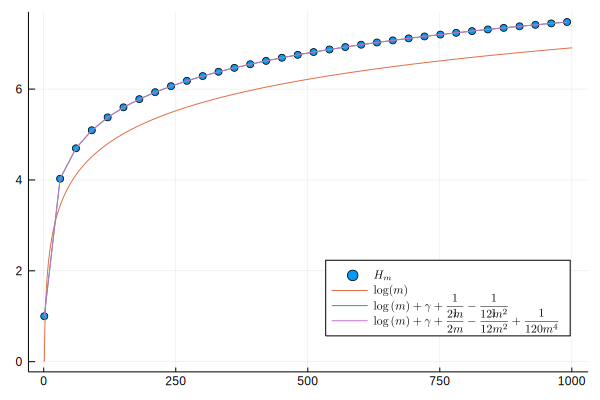

In [11]:
scatter(xpos, harmonic_values, label=L"H_m", legend=:bottomright)
plot!(log, 1:1001, label=L"\log(m)")
plot!(xpos, h1_values, 1:1001, label=latexstring(sympy.latex(h1)))
plot!(xpos, h2_values, 1:1001, label=latexstring(sympy.latex(h2)))

The two new apprximations looks much better than $\log(m)$.
But we cannot really tell which of them is better by look at the picture. So let's plot the error instead. To see anything, we have to use log scale plot because the error is so small.

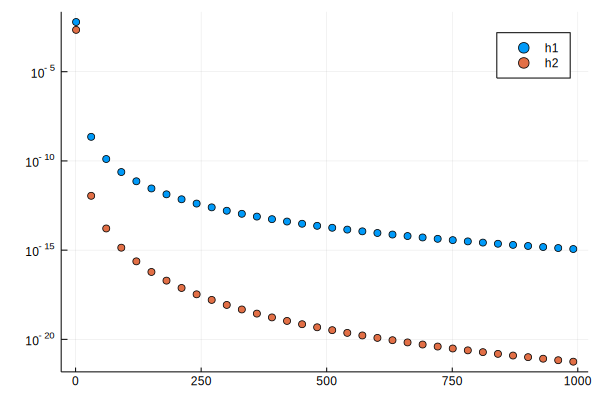

In [12]:
scatter(xpos, abs.((h1_values./harmonic_values) .- 1), label="h1", yscale=:log10)
scatter!(xpos, abs.((h2_values./harmonic_values) .- 1), label="h2", yscale=:log10)

You can see the error of the second approximation is much smaller!

In the next post, we will talk about geralized Harmonic numbers.